<a href="https://colab.research.google.com/github/hazieon/Exoplanet-Detection/blob/dev/Kepler_Exoplanet(Three_way_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [326]:
#connecting to google drive to bring in the datasets
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [327]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, ReLU, LeakyReLU
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display
import numpy as np

In [328]:
import joblib

# Kepler data stared at one field of space for four years,
# Looking deeper at the K2 data can provide a new angle of analysing exoplanet features

df = pd.read_csv(
    '/content/drive/MyDrive/KeplerExoplanet/k2_exoplanets_SUBSAMPLED_NASA_DATA.csv',
    comment='#'
)

# PREPROCESSING DATA

# Map disposition to three categories: 0=Confirmed, 1=Candidate, 2=False Positive / Refuted
df['ExoplanetClass'] = df['disposition'].map({
    'CONFIRMED': 0,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 2,
    'REFUTED': 2  # just in case some are labeled REFUTED
})

# Drop any rows that didn’t map (NaN in ExoplanetClass)
df = df[df['ExoplanetClass'].notna()]

# Ensure integer type
df['ExoplanetClass'] = df['ExoplanetClass'].astype(int)

# Define target
y = df['ExoplanetClass']

# Separate classes (just for info, optional)
confirmed = df[df['ExoplanetClass'] == 0]
candidate = df[df['ExoplanetClass'] == 1]
false_positive = df[df['ExoplanetClass'] == 2]

# Columns to drop (non-numeric or leaky)
non_numeric_columns = [
    'pl_name', 'hostname', 'disposition', 'disp_refname',
    'discoverymethod', 'disc_facility', 'soltype', 'pl_refname',
    'pl_bmassprov', 'st_refname', 'st_spectype', 'sy_refname',
    'rastr', 'decstr', 'releasedate', 'rowupdate', 'pl_pubdate',
    'ConfirmedExoplanet',   # <- remove leakage if present
    'ExoplanetClass'        # <- target itself, don’t let it leak into X
]

# Keep only numeric features (drop columns safely if they exist)
drop_cols_existing = [col for col in non_numeric_columns if col in df.columns]
df_numeric = df.drop(columns=drop_cols_existing)

# Target column separately (already defined as y)
# Select numeric features
numeric_cols = df_numeric.select_dtypes(include='number').columns
X = df_numeric[numeric_cols]

# Train/test split (stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalisation
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)


# --- Save the fitted scaler ---
scaler_path = "/content/drive/MyDrive/KeplerExoplanet/kepler_exoplanet_scaler.pkl"
joblib.dump(scaler, scaler_path)

print("✅ New scaler created and saved successfully!")
print(f"Saved to: {scaler_path}")
print(f"Scaler fitted on {len(scaler.feature_names_in_)} features.")
print("First 10 features:", scaler.feature_names_in_[:10])


# Check for NaNs and replace with 0 values
print("NaNs in X_train_normalized:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized:", np.isnan(X_test_normalized).sum())
X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0)
X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0)
print("NaNs in X_train_normalized after replacement:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized after replacement:", np.isnan(X_test_normalized).sum())



Training set distribution:
 ExoplanetClass
0    1688
1    1009
2     214
Name: count, dtype: int64
Testing set distribution:
 ExoplanetClass
0    563
1    336
2     72
Name: count, dtype: int64
✅ New scaler created and saved successfully!
Saved to: /content/drive/MyDrive/KeplerExoplanet/kepler_exoplanet_scaler.pkl
Scaler fitted on 76 features.
First 10 features: ['default_flag' 'sy_snum' 'sy_pnum' 'disc_year' 'pl_controv_flag'
 'pl_orbper' 'pl_orbpererr1' 'pl_orbpererr2' 'pl_orbperlim' 'pl_orbsmax']
NaNs in X_train_normalized: 92471
NaNs in X_test_normalized: 29987
NaNs in X_train_normalized after replacement: 0
NaNs in X_test_normalized after replacement: 0


In [329]:
# PREPROCESSING DATA

# Map disposition to three categories: 0=Confirmed, 1=Candidate, 2=False Positive / Refuted
df['ExoplanetClass'] = df['disposition'].map({
    'CONFIRMED': 0,
    'CANDIDATE': 1,
    'FALSE POSITIVE': 2,
    'REFUTED': 2  # just in case some are labeled REFUTED
})

# Drop any rows that didn’t map (NaN in ExoplanetClass)
df = df[df['ExoplanetClass'].notna()]

# Ensure integer type
df['ExoplanetClass'] = df['ExoplanetClass'].astype(int)

# Define target
y = df['ExoplanetClass']


# Separate classes (just for info, optional)
confirmed = df[df['ExoplanetClass'] == 0]
candidate = df[df['ExoplanetClass'] == 1]
false_positive = df[df['ExoplanetClass'] == 2]

# Columns to drop (non-numeric)
non_numeric_columns = [
    'pl_name', 'hostname', 'disposition', 'disp_refname',
    'discoverymethod', 'disc_facility', 'soltype', 'pl_refname',
    'pl_bmassprov', 'st_refname', 'st_spectype', 'sy_refname',
    'rastr', 'decstr', 'releasedate', 'rowupdate', 'pl_pubdate'
]

# Keep only numeric features (drop columns safely if they exist)
drop_cols_existing = [col for col in non_numeric_columns if col in df.columns]
df_numeric = df.drop(columns=drop_cols_existing)

# Target column separately
y = df_numeric['ExoplanetClass']

# Select numeric features
numeric_cols = df_numeric.select_dtypes(include='number').columns
feature_cols = [col for col in numeric_cols if col not in ['ExoplanetClass']]
X = df_numeric[feature_cols]

# Train/test split (stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Training set distribution:\n", y_train.value_counts())
print("Testing set distribution:\n", y_test.value_counts())

# Normalisation
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Check for NaNs and replace with 0 values
print("NaNs in X_train_normalized:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized:", np.isnan(X_test_normalized).sum())
X_train_normalized = np.nan_to_num(X_train_normalized, nan=0.0)
X_test_normalized = np.nan_to_num(X_test_normalized, nan=0.0)
print("NaNs in X_train_normalized after replacement:", np.isnan(X_train_normalized).sum())
print("NaNs in X_test_normalized after replacement:", np.isnan(X_test_normalized).sum())


Training set distribution:
 ExoplanetClass
0    1688
1    1009
2     214
Name: count, dtype: int64
Testing set distribution:
 ExoplanetClass
0    563
1    336
2     72
Name: count, dtype: int64
NaNs in X_train_normalized: 92471
NaNs in X_test_normalized: 29987
NaNs in X_train_normalized after replacement: 0
NaNs in X_test_normalized after replacement: 0


In [330]:
# Check normalized training data
print("\n=== Normalized Training Data ===")
print("Shape of dataset:", X_train_normalized.shape)
print("Number of rows:", X_train_normalized.shape[0])
print("Number of columns:", X_train_normalized.shape[1])
print("Total NaNs in dataset:", np.isnan(X_train_normalized).sum())
print("All numeric?", np.issubdtype(X_train_normalized.dtype, np.number))

# Check normalized test data
print("\n=== Normalized Test Data ===")
print("Shape of dataset:", X_test_normalized.shape)
print("Number of rows:", X_test_normalized.shape[0])
print("Number of columns:", X_test_normalized.shape[1])
print("Total NaNs in dataset:", np.isnan(X_test_normalized).sum())
print("All numeric?", np.issubdtype(X_test_normalized.dtype, np.number))

print("\nFeature statistics (train set):\n", pd.DataFrame(X_train).describe().T[['mean','std','min','max']].head(10))




=== Normalized Training Data ===
Shape of dataset: (2911, 76)
Number of rows: 2911
Number of columns: 76
Total NaNs in dataset: 0
All numeric? True

=== Normalized Test Data ===
Shape of dataset: (971, 76)
Number of rows: 971
Number of columns: 76
Total NaNs in dataset: 0
All numeric? True

Feature statistics (train set):
                         mean          std          min      max
default_flag        0.447613     0.497333      0.00000      1.0
sy_snum             1.051123     0.249695      1.00000      3.0
sy_pnum             1.110535     1.364298      0.00000      7.0
disc_year        2017.534024     2.033955   2011.00000   2025.0
pl_controv_flag     0.000345     0.018586      0.00000      1.0
pl_orbper          46.560676  1573.277695      0.17566  83830.0
pl_orbpererr1      17.382511   677.386764      0.00000  31600.0
pl_orbpererr2     -11.725345   476.838435 -22320.00000      0.0
pl_orbperlim       -0.001050     0.041821     -1.00000      1.0
pl_orbsmax          0.108117     0

Class weights: {np.int64(0): np.float64(0.5748420221169036), np.int64(1): np.float64(0.9616782292699042), np.int64(2): np.float64(4.534267912772585)}
Sweet-spot amplified class weights for minority class: {np.int64(0): np.float64(0.5748420221169036), np.int64(1): np.float64(0.9616782292699042), np.int64(2): np.float64(5.894548286604361)}


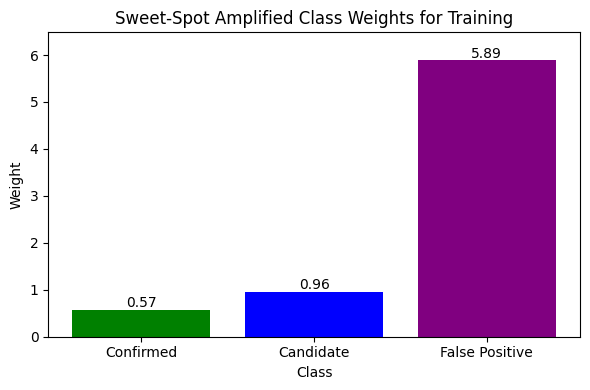

In [331]:
# =========================
# PREPROCESSING: CLASS WEIGHTS
# Adding class weights to balance the minority class (confirmed exoplanets)
# Preferred this strategy over oversampling, which would generate false data
# =========================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Compute balanced weight classes
classes = np.unique(y_train)  # unique labels in training set
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_dict = dict(zip(classes, class_weights))
print("Class weights:", class_weights_dict)

# Sweet spot amplification: moderate boost for minority class
# Multiply the minority class weight by 1.3 instead of 2.0 to avoid trashing Candidate class
max_class = max(class_weights_dict, key=class_weights_dict.get)
sweet_class_weights_dict = {k: (v*1.3 if k == max_class else v) for k, v in class_weights_dict.items()}
print("Sweet-spot amplified class weights for minority class:", sweet_class_weights_dict)

# VISUALISE CLASS WEIGHTS
plt.figure(figsize=(6,4))
classes_labels = ['Confirmed', 'Candidate', 'False Positive']  # keep your original labels
weights = [sweet_class_weights_dict[cls] for cls in classes]

plt.bar(classes_labels, weights, color=['green', 'blue', 'purple'])
plt.title('Sweet-Spot Amplified Class Weights for Training')
plt.xlabel('Class')
plt.ylabel('Weight')
plt.ylim(0, max(weights) * 1.1)
for i, w in enumerate(weights):
    plt.text(i, w + 0.05, f'{w:.2f}', ha='center')
plt.tight_layout()
plt.show()


Accuracy: 0.9598352214212152
Confusion Matrix:
 [[563   0   0]
 [  7 321   8]
 [  0  24  48]]
Classification Report:
                 precision    recall  f1-score   support

     Confirmed       0.99      1.00      0.99       563
     Candidate       0.93      0.96      0.94       336
False Positive       0.86      0.67      0.75        72

      accuracy                           0.96       971
     macro avg       0.93      0.87      0.90       971
  weighted avg       0.96      0.96      0.96       971



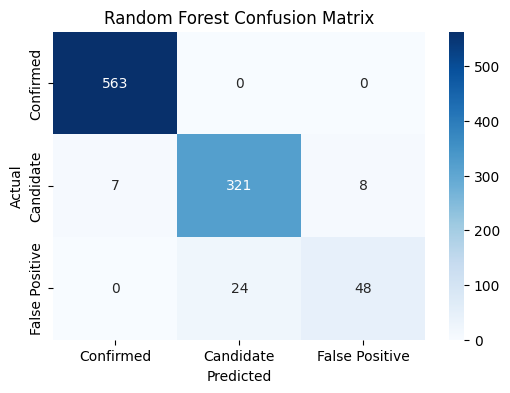


Top 10 Features by Importance:
                                    Feature  Importance
2               Number of planets in system    0.231054
0                              default_flag    0.039818
3                                 disc_year    0.034991
18  Planet radius (+ variation) (R_Jupiter)    0.029014
14    Planet radius (+ variation) (R_Earth)    0.028940
19  Planet radius (- variation) (R_Jupiter)    0.028731
17      Planetary radius (in Jupiter radii)    0.028226
75             Gaia magnitude (- variation)    0.027187
13                  Planet radius (R_Earth)    0.025879
15    Planet radius (- variation) (R_Earth)    0.025020


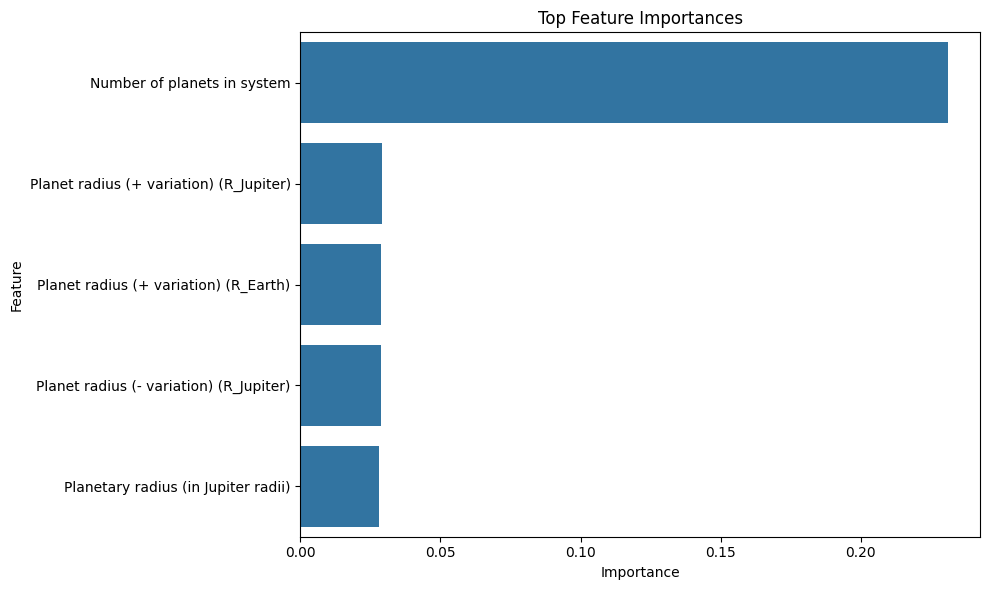

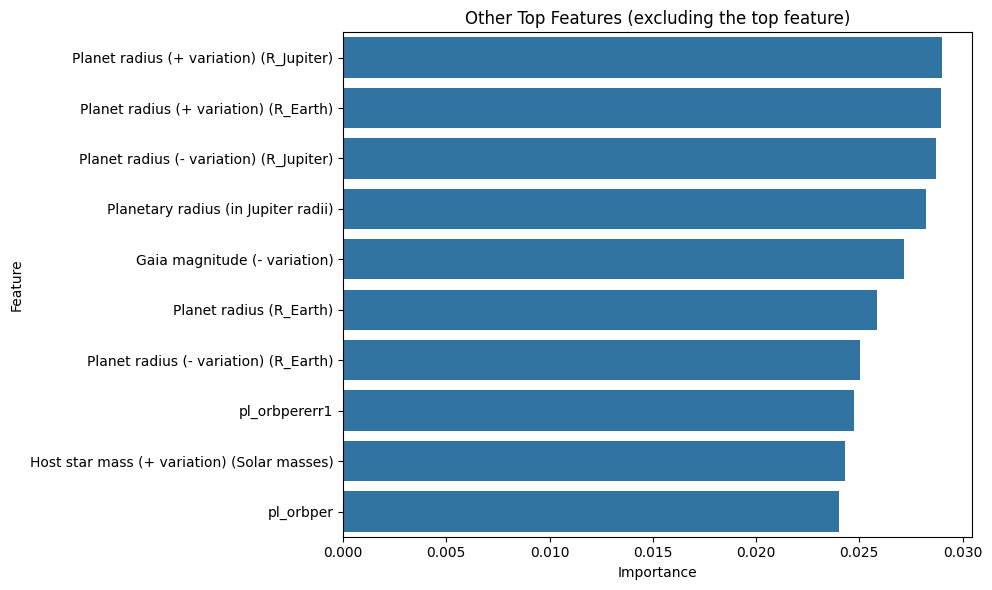

In [332]:
# ==========================================================
# RANDOM FOREST CLASSIFIER - Classical ML analysis
# ==========================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import pandas as pd

# ==========================================================
# We already have X_train_normalized, X_test_normalized, y_train, y_test from preprocessing
# ==========================================================

rf = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=10,
    max_features='sqrt',
    random_state=42,
    class_weight=sweet_class_weights_dict  # same weights as NN
)

# ==========================================================
# RUNNING THE MODEL
# ==========================================================
# Fit the model
rf.fit(X_train_normalized, y_train)

# Predict
y_pred = rf.predict(X_test_normalized)

# ==========================================================
# EVALUATION
# ==========================================================
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(
    y_test, y_pred,
    target_names=['Confirmed', 'Candidate', 'False Positive']
))

# ==========================================================
# VISUALISATION OF RESULTS
# ==========================================================
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Confirmed','Candidate','False Positive'],
    yticklabels=['Confirmed','Candidate','False Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()

# ==========================================================
# FEATURE IMPORTANCES
# ==========================================================
readable_names = {
    'sy_pnum': 'Number of planets in system',
    'st_masserr1': 'Host star mass (+ variation) (Solar masses)',
    'st_masserr2': 'Host star mass (- variation) (Solar masses)',
    'sy_disterr1': 'System distance (+ variation) (pc)',
    'sy_disterr2': 'System distance (- variation) (pc)',
    'pl_orbsmaxerr1': 'Semi-major axis (+ variation) (AU)',
    'pl_orbsmaxerr2': 'Semi-major axis (- variation) (AU)',
    'pl_radjerr2': 'Planet radius (- variation) (R_Jupiter)',
    'pl_radjerr1': 'Planet radius (+ variation) (R_Jupiter)',
    'pl_radeerr1': 'Planet radius (+ variation) (R_Earth)',
    'pl_radeerr2': 'Planet radius (- variation) (R_Earth)',
    'pl_rade': 'Planet radius (R_Earth)',
    'sy_dist': 'System distance (pc)',
    'st_tefferr2': 'Host star temperature (- variation) (K)',
    'st_tefferr1': 'Host star temperature (+ variation) (K)',
    'st_mass': 'Host star mass (Solar masses)',
    'pl_orbsmaxlim': 'Semi-major axis limit flag',
    'pl_radj': 'Planetary radius (in Jupiter radii)',
    'sy_kmag': 'Star brightness (infrared, K-band)',
    'sy_gaiamagerr1': 'Gaia magnitude (+ variation)',
    'sy_gaiamagerr2': 'Gaia magnitude (- variation)'
}
# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns
readable_feature_names = [readable_names.get(f, f) for f in feature_names]

# Build DataFrame of importances
feat_imp_df = pd.DataFrame({
    'Feature': readable_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\nTop 10 Features by Importance:")
print(feat_imp_df.head(10))

# Remove redundant features if any
feat_imp_df = feat_imp_df[~feat_imp_df['Feature'].isin(['default_flag', 'disc_year'])]

# Identify top feature
top_feature = feat_imp_df.iloc[0]['Feature']
top_feat_df = feat_imp_df[feat_imp_df['Feature'] == top_feature]
other_feats_df = feat_imp_df[feat_imp_df['Feature'] != top_feature]

# ==========================================================
# VISUALISATION OF FEATURE IMPORTANCE
# ==========================================================
feat_imp_top5 = feat_imp_df.head(5)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_top5)
plt.title('Top Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=other_feats_df.head(10))
plt.title('Other Top Features (excluding the top feature)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [333]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import Input, regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

model = Sequential([
    Input(shape=(X_train_normalized.shape[1],)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
])

# Add hidden layers
model.add(Dense(units=36, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dense(units=18, activation='relu'))  # intermediate dense layer
model.add(Dropout(0.4))  #  dropout for minority class learning & prevent overfitting
model.add(Dense(units=18, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.4))

# Add the output layer
model.add(Dense(units=3, activation='softmax'))  # For three-way classification

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the summary of the model
model.summary()


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_224 (Dense)               │ (None, 64)             │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 36)             │         2,340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 18)             │           666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 18)             │           342 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 18)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_228 (Dense)               │ (None, 3)              │            57 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,589 (33.55 KB)

 Trainable params: 8,461 (33.05 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.3884 - loss: 1.6301 - val_accuracy: 0.5678 - val_loss: 1.1900
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4532 - loss: 1.3430 - val_accuracy: 0.5695 - val_loss: 1.1496
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4678 - loss: 1.2270 - val_accuracy: 0.5712 - val_loss: 1.0749
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5301 - loss: 1.1840 - val_accuracy: 0.5832 - val_loss: 0.9904
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5574 - loss: 1.0705 - val_accuracy: 0.5849 - val_loss: 0.8943
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5816 - loss: 1.0450 - val_accuracy: 0.6038 - val_loss: 0.8019
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6087 - loss: 0.9358 - val_accuracy: 0.6123 - val_loss: 0.7427
Epoch 8/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6500 - loss: 0.8891 - val_accuracy: 0.6295 - val_loss:

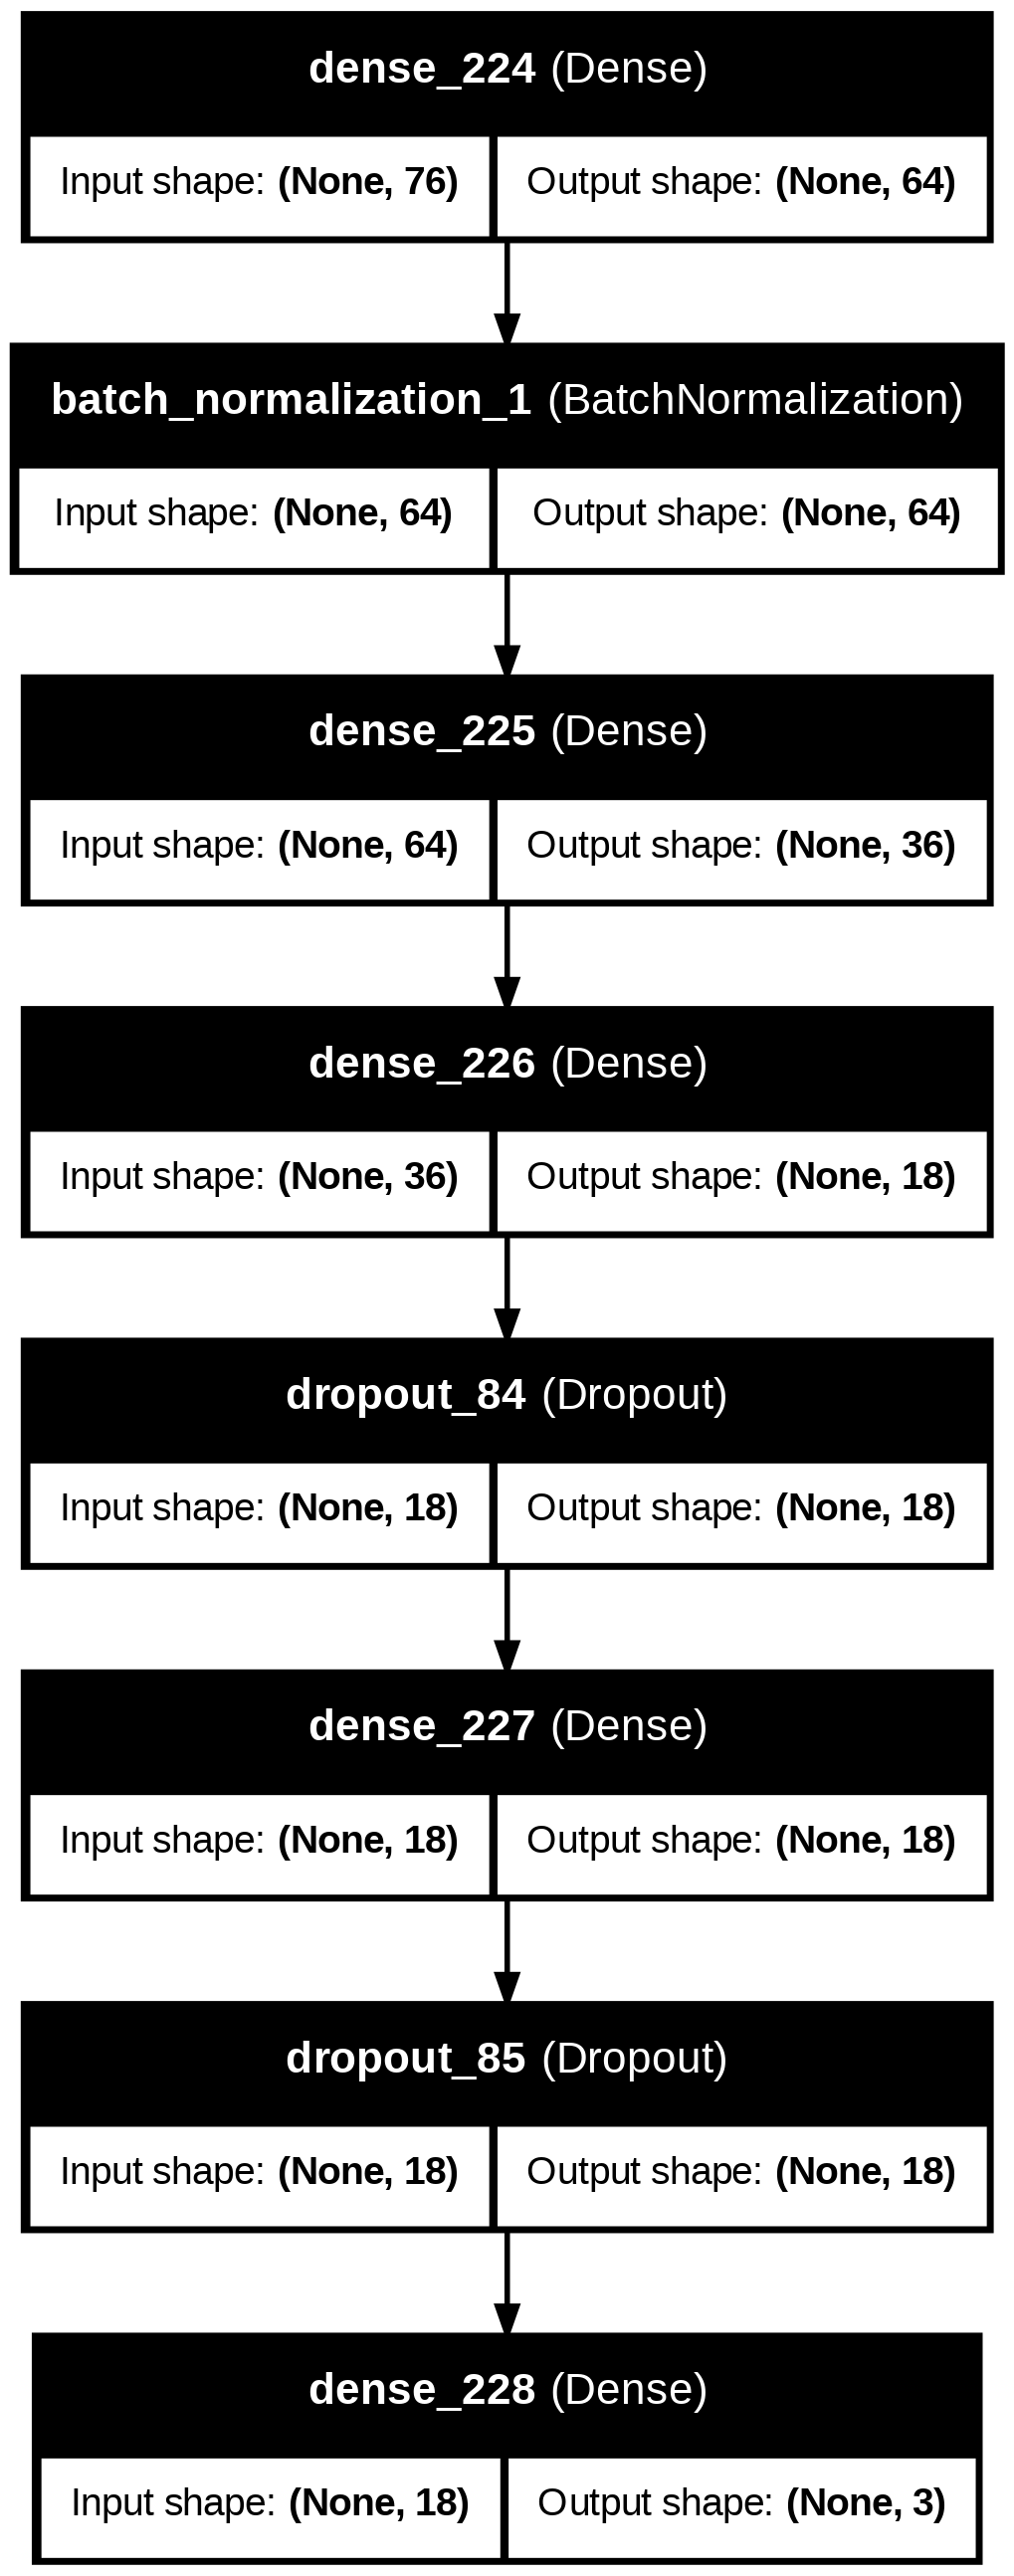

In [334]:
# Train the model
history = model.fit(
    X_train_normalized,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=sweet_class_weights_dict
)

# Make predictions
y_pred_prob = model.predict(X_test_normalized)
y_pred = y_pred_prob.argmax(axis=1)  # Take the class with highest probability

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_normalized, y_test)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

# Plot the model architecture and display it
plot_file = 'model_plot.png'
plot_model(model, to_file=plot_file, show_shapes=True, show_layer_names=True)

# Display the plot inline
display(Image(filename=plot_file))


                precision    recall  f1-score   support

     Confirmed       0.98      0.99      0.99       563
     Candidate       0.97      0.74      0.84       336
False Positive       0.47      0.90      0.62        72

      accuracy                           0.90       971
     macro avg       0.80      0.88      0.81       971
  weighted avg       0.93      0.90      0.91       971



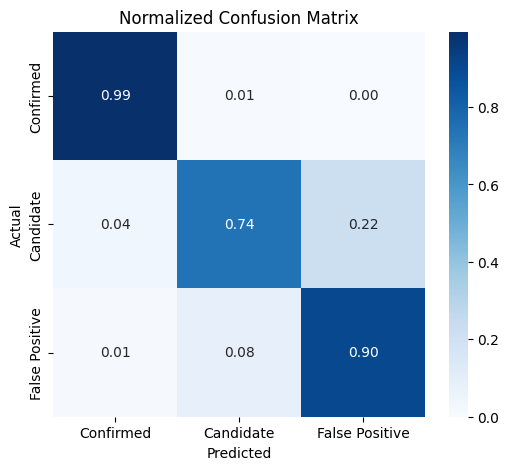

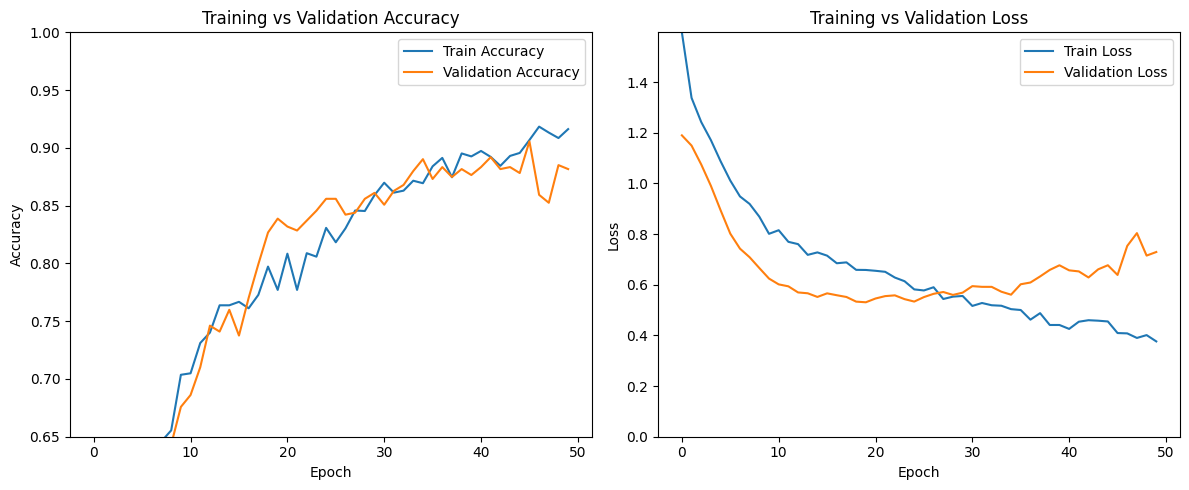

In [335]:
# VISUALISE THE RESULTS

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Classification report
# Use zero_division=0 to avoid warnings when a class has no predicted samples
print(classification_report(
    y_test,
    y_pred,
    target_names=['Confirmed', 'Candidate', 'False Positive'],
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')  # normalized per row
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='.2f', cmap='Blues',
    xticklabels=['Confirmed','Candidate','False Positive'],
    yticklabels=['Confirmed','Candidate','False Positive']
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Normalized Confusion Matrix')
plt.show()

# Optionally, plot training curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.65, 1.0)
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history.history['loss'] + history.history['val_loss']))
plt.legend()

plt.tight_layout()
plt.show()


In [336]:
def predict_exoplanets(csv_path):
    import pandas as pd
    import numpy as np
    import joblib

    print(f"\nPredicting exoplanets from: {csv_path}")

    global model  # model must already be loaded

    # Load scaler
    try:
        scaler = joblib.load("/content/drive/MyDrive/KeplerExoplanet/kepler_exoplanet_scaler.pkl")
    except Exception as e:
        print(f"Error loading scaler: {e}")
        return None

    # Load CSV
    try:
        df = pd.read_csv(csv_path, comment="#")
        df.columns = df.columns.str.strip()
    except Exception as e:
        print(f"Error reading CSV: {e}")
        return None

    # Drop non-numeric columns
    drop_cols = [
        'pl_name', 'hostname', 'disposition', 'disp_refname', 'discoverymethod',
        'disc_facility', 'soltype', 'pl_refname', 'pl_bmassprov', 'st_refname',
        'st_spectype', 'sy_refname', 'rastr', 'decstr', 'releasedate',
        'rowupdate', 'pl_pubdate', 'ExoplanetClass'
    ]
    df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

    # Prepare features
    expected = list(scaler.feature_names_in_)
    df_features = pd.DataFrame({c: pd.to_numeric(df[c], errors="coerce").fillna(0.0)
                                if c in df.columns else np.zeros(len(df))
                                for c in expected})
    missing = [c for c in expected if c not in df.columns]
    if missing:
        print(f"Warning: {len(missing)} missing features replaced with 0")

    # Predict
    try:
        X_scaled = scaler.transform(df_features)
        preds = model.predict(X_scaled, verbose=0)

        if preds.ndim > 1 and preds.shape[1] > 1:
            labels = np.argmax(preds, axis=1)
            conf = preds.max(axis=1)
        else:
            labels = (preds > 0.5).astype(int).flatten()
            conf = preds.flatten()

        label_map = {
            0: "Confirmed Planet",
            1: "Candidate Planet",
            2: "False Positive / Non-Planet"
        }

        df["Predicted_Label"] = labels
        df["Confidence"] = conf.astype(float)
        df["Prediction"] = df["Predicted_Label"].map(label_map)

        # Output
        print("\nPrediction Summary:")
        print(df["Prediction"].value_counts().rename_axis("Prediction").reset_index(name="Count"))
        print("\nFull Predictions:")
        print(df[["Predicted_Label", "Confidence", "Prediction"]].to_string(index=False))

        return df

    except Exception as e:
        print(f"Prediction failed: {e}")
        df["Predicted_Label"] = "Error"
        return df


# Run on unseen data
results_df = predict_exoplanets(
    "/content/drive/MyDrive/KeplerExoplanet/K2_subsample_10_Exoplanets_unseen.csv"
)



Predicting exoplanets from: /content/drive/MyDrive/KeplerExoplanet/K2_subsample_10_Exoplanets_unseen.csv

Prediction Summary:
                    Prediction  Count
0             Confirmed Planet     16
1  False Positive / Non-Planet      3
2             Candidate Planet      2

Full Predictions:
 Predicted_Label  Confidence                  Prediction
               0    0.997395            Confirmed Planet
               0    0.998949            Confirmed Planet
               0    0.894782            Confirmed Planet
               0    0.991511            Confirmed Planet
               1    0.907778            Candidate Planet
               2    0.562100 False Positive / Non-Planet
               1    0.901190            Candidate Planet
               2    0.562101 False Positive / Non-Planet
               2    0.843633 False Positive / Non-Planet
               0    0.999969            Confirmed Planet
               0    0.996236            Confirmed Planet
               0  

In [340]:
# ------------------------------
# Run on user-specified data (local file or URL)
# ------------------------------
user_csv_path = input("Enter CSV path or URL for new exoplanet data: ").strip()

# Ensure it's a string
if not isinstance(user_csv_path, str) or len(user_csv_path) == 0:
    print("Invalid input. Please provide a CSV path or URL as a string.")
else:
    results_df = predict_exoplanets(user_csv_path)

    if results_df is not None and "Prediction" in results_df.columns:
        print("\n==============================")
        print("Full Predictions for All Rows")
        print("==============================")
        print(results_df[["Predicted_Label", "Confidence", "Prediction"]].reset_index(drop=True))

        # Count by category and average confidence
        summary = results_df.groupby("Prediction")["Confidence"].agg(["count", "mean"]).reset_index()
        summary.rename(columns={"count": "Number_of_Rows", "mean": "Average_Confidence"}, inplace=True)

        print("\n==============================")
        print("Prediction Summary")
        print("==============================")
        print(summary)

# HELLO NASA FRIENDS :)
# TEST OUT WITH THE CSV FILE BELOW OF UNSEEN EXOPLANET DATA -
# use the CSV file path provided
# '/content/drive/MyDrive/KeplerExoplanet/K2_subsample_100_Exoplanets_unseen.csv'

Enter CSV path or URL for new exoplanet data: /content/drive/MyDrive/KeplerExoplanet/K2_subsample_100_Exoplanets_unseen.csv

Predicting exoplanets from: /content/drive/MyDrive/KeplerExoplanet/K2_subsample_100_Exoplanets_unseen.csv

Prediction Summary:
                    Prediction  Count
0             Confirmed Planet     53
1             Candidate Planet     28
2  False Positive / Non-Planet     20

Full Predictions:
 Predicted_Label  Confidence                  Prediction
               1    0.979530            Candidate Planet
               1    0.988396            Candidate Planet
               1    0.988496            Candidate Planet
               1    0.824915            Candidate Planet
               1    0.999389            Candidate Planet
               1    0.997347            Candidate Planet
               1    0.974870            Candidate Planet
               1    0.992936            Candidate Planet
               1    0.992961            Candidate Planet
       